# Move-to-Front

A codificação *move-to-front* é uma forma de codificação de dados apropriada para melhorar a performance dos codificadores de entropia. Essa codificação consiste em utilizar um dicionário adapatativo para indexar os símbolos produzidos por uma fonte. Os símbolos são condificados por seu índice no dicionário, porém após codificar cada símbolo, o dicionário é alterado, levando o último símbolo codificado para o início do dicionário. Este método foi proposto por Boris Yakovlevich Ryabko (1980) e de forma independente por Peter Elias (1984).

Leia mais sobre o move-to-front: 
- https://en.wikipedia.org/wiki/Move-to-front_transform
- [David Salomon, *Data Compression: The Complete Reference*, Springer, 2013](https://books.google.com.br/books?id=P4XjBwAAQBAJ&pg=PA16)

Procure também as variações do *move-to-front*.
- move-ahead-k 
- wait-c-and-move
- wait-c-and-move-ahead-k

Iremos implementar o *move-to-front* e utilizá-lo na codificação de uma imagem.

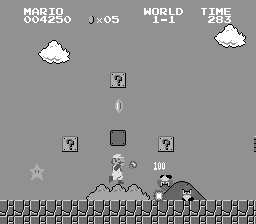

In [1]:
X = rgb2gray (imread ('imgs/Mario_Bros.png'));
imshow(X);
sX = size(X);

Vamos definir abaixo a função para fazer a codificação usando o move-to-front e a função de decodificação. 

Para realizar a codificação iremos utilizar um dicionário inicial com a lista dos símbolos utilizados pela fonte. Caso este dicionário inicial não seja fornecido para a função, esta criará um lista de todos os símbolos (*unique*) existentes no sinal a ser codificado.

In [2]:
function [enc, start_dic] = mov2frontenco( X, dic )
% move-to-front encoder
% enc = mov2frontenco(X, dic)
% [enc, dic] = mov2frontenco(X)

  if nargin < 2, start_dic = dic = unique (X(:)); endif

  enc = [];
  for i = 1 : length(X),
    id = find( dic == X(i) );
    enc = [enc; id-1];
    dic(id) = [];
    dic = [X(i); dic];
  endfor

endfunction

In [3]:
function X = mov2frontdeco( enc, dic )
% move-to-front decoder
% X = mov2frontdeco( enc, dic )

  X = [];
  for i = 1:length(enc),
     X = [X; dic(enc(i)+1)];
     dic(enc(i)+1) = [];
     dic = [X(end); dic];
  endfor

endfunction

Agora iremos utilizar as funções definidas para realizar a codificação da imagem do Mário Bros. Faremo em seguida um histograma do resulado da codificação (a sequência de índices, referenciando o dicionário, que será utilizada na decodificação).

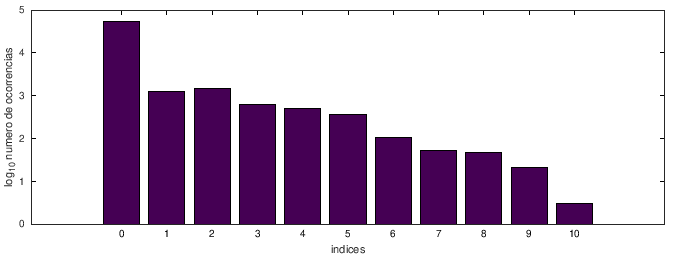

In [4]:
[enc, dic] = mov2frontenco( X(:) );
maxe = max(enc);
[nn, xx] = hist(enc,[0:maxe]);
figure("position",get(0,"screensize")./[1 1 2 3]);
bar(xx, log10(nn)); ylabel('log_{10} numero de ocorrencias'); xlabel('indices');

De forma geral, observaremos que a saída da codificação *move-to-front* será uma sequência de índices onde os menores índices terão maior probabilidade, pois os símbolos mais frequentes tendem a ficar no início do dicionário.

Em seguida, iremos aproveitar esta característica observada na distribuição da saída do codificador para realizar uma codificação de entropia. Utilizamos o código de Huffman neste exemplo.

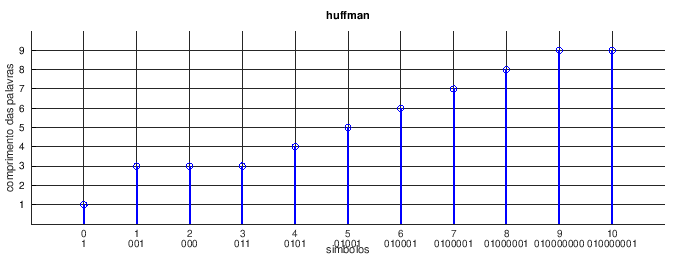

In [5]:
pkg load communications
% maximum likelihood estimation of the distribution
p = nn./sum(nn);
hdic = huffmandict([0:maxe], p);
len = []; for i = 1:length(hdic), len(i)=length(hdic{i}); endfor;
figure("position",get(0,"screensize")./[1 1 2 3])
stem([0:maxe],len,'b-','linewidth',5); axh=axis; axh(1)=-1; axh(2)=maxe+1; axis(axh);
hxl=xlabel('simbolos'); xp=get(hxl,'position'); xp(2)-=-0.02; set(hxl,'position',xp);
ylabel('comprimento das palavras'); title('huffman');
set(gca,'xtick',[0:maxe]); set(gca,'ytick',[1:max(len)]); grid on;
tlbl = get(gca,'xticklabel'); 
for i = 1:maxe+1, tlbl{i}=cstrcat(tlbl{i},'\n',strrep(num2str(hdic{i}),' ','')); endfor
set(gca,'xticklabel',tlbl);

Observe que os índices menores (mais prováveis) serão codificados por palavras com menor comprimento. Isto fará com que o comprimento esperado final da representação dos dados seja menor. Como sabemos, o código de Huffman é o código ótimo, dentre os códigos de símbolo. Vamos então utilizar o código de Huffman criado para codificar os dados. Note que a sequencia de bits gerada poderá não ter um comprimento múltiplo de 8. Desta forma, para escrever os dados byte a byte em um arquivo, vamos adicionar ao final da sequência tantos zeros quanto forem necessários para que o comprimento final da sequência seja um múltiplo de 8, sendo assim possível dividir em bytes (o que faremos usando a função *reshape* para dispor cada byte como uma linha da matriz).

In [6]:
henc = huffmanenco (enc+1, hdic);
nbits = length(henc);
nbytes = ceil(nbits/8); % number of bytes required
henc = [henc zeros(1,nbytes*8-nbits)]; % pad with zeros to make it a multiple of 8
henc = reshape(henc,nbytes,8); % arrange each byte in a row 

Será necessário também guardar o código de Huffman utilizado, para que o decodificador seja capaz de recuperar a mensagem. Para tanto, vamos transforma a estrutura de célula que armazena a tabela de código Huffman em uma *string*, utilizando o ponto-e-vírgula como reparador das palavas do código.

In [7]:
# write huffman dictionary as a string
shdic = '';
for i = 1:length(hdic),
  s = num2str(hdic{i});
  s = s(s ~= ' ');
  shdic = cstrcat(shdic,s,';');
endfor;
shdic=shdic(1:end-1);
shdic

shdic = 1;001;000;011;0101;01001;010001;0100001;01000001;010000000;010000001


Vamos agora armazenar em um arquivo binário os dados necessários para reconstruir a imagem original. Para ser possível realizar a reconstrução, precisaremos armazenar também o tamanho da imagem original, o dicionário utilizado no método move-to-front e o número de bits total da codificação huffman.

Por fim calculamos a taxa de compressão obtida.

In [8]:
filename = '/tmp/mario.mfh';
fid = fopen (filename,'w');
fprintf (fid,'# m2fh\n%d %d\n%d\n',sX,nbits); % write a header with format name, image size and number of bits used
fprintf (fid,cstrcat(repmat ('%d ',1,length(dic)),'\n'),dic');
fprintf (fid,'%s\n',shdic);
fwrite (fid, uint8( bi2de (henc) ), 'uint8'); % write image data
fclose(fid);
dr = dir('/tmp/mario.mfh');
printf ('%s has %d bytes\ncompression ratio = %.2f', dr.name, dr.bytes, prod(sX)/dr.bytes);

mario.mfh has 8661 bytes
compression ratio = 6.62
compression ratio = 6.62


Após salvar o arquivo comprimido da imagem, vamos verificar se este processo realmente funcionou. Vamos agora ler o arquivo binário e recuperar a imagem.

Vamos inicialmente ler todas as informações do arquivo.

In [9]:
fid = fopen(filename,'r');
header = fgetl (fid);
if strcmp(header,'# m2fh'),
  im_size = str2num(fgetl (fid));
  n_bits = str2num(fgetl (fid));
  dic = str2num(fgetl (fid))';
  s_hdic = strsplit (fgetl (fid), ';');
  data = fread (fid, Inf, 'uint8');
endif
fclose(fid);

O primeiro passo da decodificação é a decodificação Huffman. Precisaremos então recriar a célula com o dicionário de Huffman utilizado, para em seguida utilizá-lo na função *huffmandeco*. Lembre-se de remover os zeros adicionados ao final (se este for o caso).

In [10]:
h_dic = {};
for i = 1:length(s_hdic),
  h_dic{i} = str2num(regexprep (s_hdic{i},'([01])','$1 '));
endfor

dbv = de2bi(data); % convert back to binary vector
dbv = reshape(dbv, 1, prod(size(dbv)));
dbv = dbv(1:n_bits); % remove padded zeros >>> if we dont cut it might generate warnings and we will need to remove the error entry
back = huffmandeco (dbv, h_dic);
% >> remove comment if you dont store the nbits value
%id_invalid = find(back == -1);
%back(id_invalid) = [];

Por fim iremos realizar a decodificação do *move-to-front*, ajustar os pixels reconstruídos para as dimensões originais da imagem e exibir a imagem decodificada.

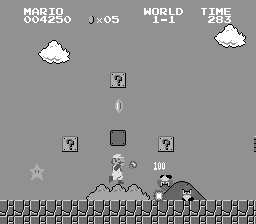

In [11]:
Xr = mov2frontdeco( back-1, dic );
Xr = reshape(Xr,im_size);
imshow(uint8(Xr));